# REINFORCE Monte Carlo

This notebook demonstates the simplest policy gradient method, REINFORCE. This is the Monte-Carlo version of REINFORCE, which means the model can only be updated after the episode has terminated. We will be using the Cartpole environment, since episode termination is easy to achieve on this problem. Monte-Carlo algorithms are not well suited to environments that don't provide a straight forward termination path, because they can get stuck in an infinite loop and never complete the first episode, due to not being able to learn during the episode.

This is a pure policy gradient approach, which means we will learn the policy function directly and won't be using a value function for criticing the actions (like the actor-critic methods). The policy function in this case is a 3 layer multi-layer perceptron. The algorithm is on-policy, so it starts by generating an episode $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$, following the policy, $\pi_\theta$, until the terminal time step $T$. After the episode has completed the policy, $\pi_\theta$, learns by updating its weights, $\theta$, using the following update rule:
$$\theta \leftarrow \theta + \alpha \nabla_\theta \log(\pi_\theta(a_t | s_t))G_t $$
, where $t$ is the time step, $\alpha$ is the step size (or learning rate), and $G_t$ is the discounted return from timestep $t$, given by,
$$G_t \leftarrow \sum_{k=t+1}^{T}\gamma^{k-t-1}R_k .$$

For more information on the REINFORCE Monte Carlo algorithm, see the blog post by Jordi Torres [Policy-Gradient Methods](https://towardsdatascience.com/policy-gradient-methods-104c783251e0), and chapter 13 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).


In [1]:
import os
import gymnasium as gym
import numpy as np
from IPython.display import Video
import jax
import flax.linen as nn
from jax import random
from jax import grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [2]:
# Type of environment, options include:
# CartPole-v1
ENV_TYPE = "CartPole-v1"

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/reinforce/'

In [3]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_actions = env.action_space.n
obs_dims = env.observation_space.shape
obs_upper_bounds = env.observation_space.high
obs_lower_bounds = env.observation_space.low

## Create The Policy 

In [4]:
class _policy_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(64)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x, _ = env.reset()
rng_key = random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.



                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[4]   │ float32[2]   │                         │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense      │ float32[4]   │ float32[256] │ bias: float32[256]      │
│         │            │              │              │ kernel: float32[4,256]  │
│         │            │              │              │                         │
│         │            │              │              │ 1,280 (5.1 KB)          │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense      │ float32[256] │ float32[64]  │ bias: float32[64]       │
│         │            │   

In [5]:
def loss_fn(variables, states, actions, weights):
    action_dists = policy_fn.apply(variables, states)
    probs = action_dists[jnp.arange(len(actions)), actions]
    log_probs = jnp.log(probs)
    loss = -(log_probs * weights).mean()
    return loss 

## Learn The Optimal Action-Value Function

In [6]:
# Number of episodes to train on
episodes = 53
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.003

variables = policy_fn.init(rng_key, dummy_x)

optimizer = optax.adam(learning_rate=alpha)
opt_state = optimizer.init(variables)

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE,
        fps=30
        )

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0
    rewards = []
    state, info = env.reset()
    states = []
    actions = []
    # Generate an episode following the policy
    while not (terminated or truncated):
        states.append(state)
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(variables, state)
        action_dist = np.array(action_dist).astype(np.float64)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        # action = jax.random.choice(rng_key, jnp.arange(num_actions), p=action_dist)
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        actions.append(action)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(reward)
        state = next_state


    rewards = jnp.array(rewards)
    states = jnp.array(states)
    actions = jnp.array(actions)

    T = len(states)
    weights = []
    # Update the policies parameters
    for t, state in enumerate(states):
        G = 0
        for k in range(t, T):
            G += (gamma**(k - t)) * rewards[k]
        weights.append(G)
    weights = jnp.array(weights)

    grads = grad(loss_fn, argnums=0)(variables, states, actions, weights)
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
            

    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.env.return_queue).flatten()[-episode_window:]) :.2f}')

/home/ubuntu22/repos/reinforcement-learning-algorithms/venv-pre/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:282: UserWarning: WARN: Overwriting existing videos at /home/ubuntu22/repos/reinforcement-learning-algorithms/videos/reinforce folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 5 Average Returns: 34.60
Episode 10 Average Returns: 55.00
Episode 15 Average Returns: 80.20
Episode 20 Average Returns: 128.60
Episode 25 Average Returns: 122.20
Episode 30 Average Returns: 96.80
Episode 35 Average Returns: 152.40
Episode 40 Average Returns: 166.80
Episode 45 Average Returns: 254.60
Episode 50 Average Returns: 189.60


## Plot The Results

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

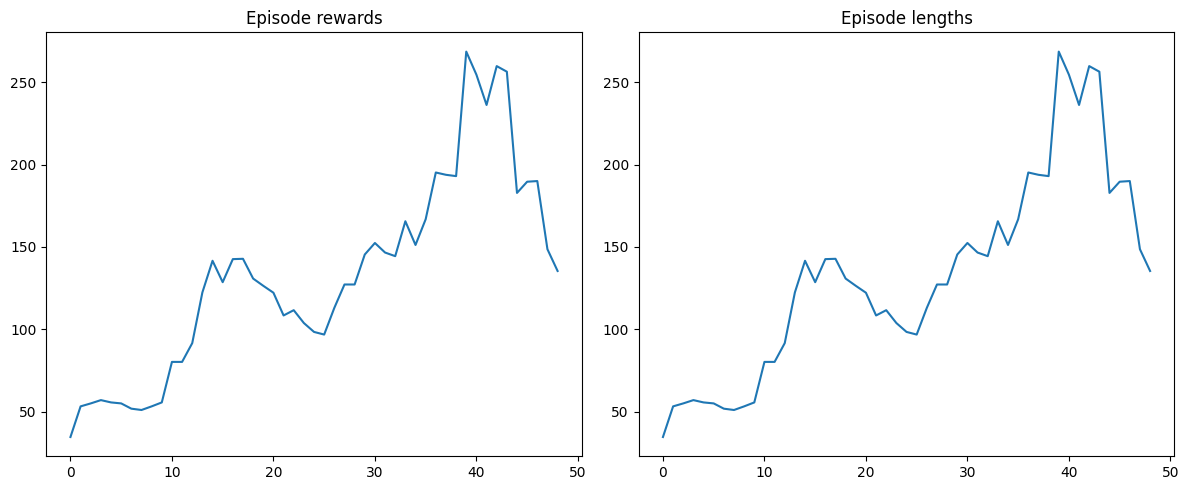

In [9]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [10]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 10

In [11]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 20

In [12]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [16]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [17]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

### Episode 50

In [15]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-50.mp4")